In [1]:
elastic_rods_dir = '../../add_params_elastic_rods/python'
weaving_dir = '../'
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
import copy

# Reloadable libraries
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (initialize_linkage, 
                                   update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj)
from compute_curve_from_curvature import (match_geo_curvature_and_edge_len,
                                          get_curve_from_angle,
                                          get_laser_cutting_patter)
from linkage_utils import order_segments_by_strips, get_turning_angle_and_length_from_ordered_rods

In [2]:
# Sphere Parameters
default_camera_parameters = ((3.466009282140468, -4.674139805388271, -2.556131049738206), (-0.21402574298422497, -0.06407538766530313, -0.9747681088523519),(0.1111, 0.1865, 0.5316))
RIBBON_CS = [1, 10]
ISO_CS = [4, 4]
MODEL_PATH = osp.join(weaving_dir + 'models/equal_edge_atI.obj')
SUBDIVISION_RESOLUTION = 60
REGULARIZATION_WEIGHT = 0.05

In [3]:
def input_linkage(cross_section = ISO_CS, subdivision_res = SUBDIVISION_RESOLUTION, model_path = MODEL_PATH, cam_param = default_camera_parameters):
    l = elastic_rods.RodLinkage(model_path, subdivision_res, False)
    driver=l.centralJoint()
    l.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, cross_section, stiffAxis=elastic_rods.StiffAxis.D1))
#     l.set_design_parameter_config(use_restLen = True, use_restKappa = False)
#     elastic_rods.designParameter_solve(l, regularization_weight = 0.1)
    jdo = l.dofOffsetForJoint(driver)
    fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
    elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)
    view = linkage_vis.LinkageViewer(l, width=1024, height=640)
    view.setCameraParams(cam_param)
    return l, view

In [4]:
with so(): input_weaver_linkage, input_weaver_view = input_linkage(model_path = MODEL_PATH, cam_param = default_camera_parameters, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION)
# input_weaver_view.update(scalarField=get_distance_to_center_scalar_field(input_weaver_linkage))
import vis.fields
import matplotlib.cm as cm
# sf = vis.fields.ScalarField(input_weaver_linkage, 0.5 * np.ones((input_weaver_linkage.numSegments(), input_weaver_linkage.segment(0).rod.numVertices())), colormap=cm.viridis, vmin = 0, vmax = 1)
# input_weaver_view.update(scalarField=sf)


input_weaver_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [5]:
with so(): straight_weaver_linkage, straight_weaver_view = initialize_linkage(model_path = MODEL_PATH, cam_param = default_camera_parameters, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION)
export_linkage_geometry_to_obj(straight_weaver_linkage, 'sphere_straight.obj')
# straight_weaver_view.update(scalarField=sf)

straight_weaver_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

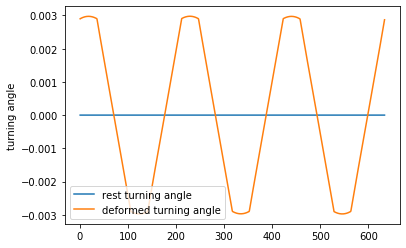

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [6]:
with so(): start_linkage, start_view = initialize_linkage(model_path = MODEL_PATH, cross_section = ISO_CS, subdivision_res=SUBDIVISION_RESOLUTION)
compare_turning_angle(start_linkage, esp = 0, remove_zeros = True)
# start_view.update(scalarField=sf)
start_view.show()

In [7]:
curr_linkage = copy.deepcopy(start_linkage)
curr_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = False)
with so():
    for i in range(20):
        curr_linkage = update_rest_curvature(curr_linkage)

In [8]:
free_joint_linkage = copy.deepcopy(curr_linkage)
free_joint_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, RIBBON_CS, stiffAxis=elastic_rods.StiffAxis.D1))
driver=free_joint_linkage.centralJoint()
jdo = free_joint_linkage.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
with so(): elastic_rods.compute_equilibrium(free_joint_linkage, fixedVars=fixedVars)
view = linkage_vis.LinkageViewer(free_joint_linkage, width=1024, height=640)
view.setCameraParams(default_camera_parameters)
# view.update(scalarField=sf)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [3]:
def design_parameter_linkage(cross_section = ISO_CS, subdivision_res = SUBDIVISION_RESOLUTION, model_path = MODEL_PATH, cam_param = default_camera_parameters, regularization_weight = 0.1):
    l = elastic_rods.RodLinkage(model_path, subdivision_res, False)
    driver=l.centralJoint()
    l.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, cross_section, stiffAxis=elastic_rods.StiffAxis.D1))
    l.set_design_parameter_config(use_restLen = True, use_restKappa = True)
    elastic_rods.designParameter_solve(l, regularization_weight = regularization_weight)
    jdo = l.dofOffsetForJoint(driver)
    fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
    elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)
    view = linkage_vis.LinkageViewer(l, width=1024, height=640)
    view.setCameraParams(cam_param)
    return l, view

In [4]:
with so(): curved_linkage, curved_view = design_parameter_linkage(model_path = MODEL_PATH, cam_param = default_camera_parameters, cross_section = RIBBON_CS, subdivision_res = SUBDIVISION_RESOLUTION, regularization_weight = 0.05)
# curved_view.update(scalarField=sf)
curved_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [11]:
la.norm(curved_linkage.gradient())

1.9453680020717185e-06

In [12]:
def full_optimization_linkage(cross_section = ISO_CS, subdivision_res = SUBDIVISION_RESOLUTION, model_path = MODEL_PATH, cam_param = default_camera_parameters, regularization_weight = 0.1):
    l = elastic_rods.RodLinkage(model_path, subdivision_res, False)
    driver=l.centralJoint()
    l.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, cross_section, stiffAxis=elastic_rods.StiffAxis.D1))
    l.set_design_parameter_config(use_restLen = True, use_restKappa = False)
#     elastic_rods.designParameter_solve(l, regularization_weight = regularization_weight)
    jdo = l.dofOffsetForJoint(driver)
    fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
    elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)
    view = linkage_vis.LinkageViewer(l, width=1024, height=640)
    view.setCameraParams(cam_param)
    return l, view